In [1]:
import pickle
from sql_scripts import create_connection, encode_array_for_sql
from sql_scripts import decode_array_from_sql, train_val_load

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import keras

# # from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold, ShuffleSplit

# custom functions
from speech_dependencies import save_model_to_disk, graph_spectrogram, load_waves
from model_dependencies import new_keras, plot_results
plt.rcParams['figure.dpi'] = 80

## Creating a Directory for the Files

In [2]:
folder_names = [f for f in os.listdir('train/audio') if not 'background' in f]
folder_names.sort()

file = open("train/testing_list.txt", "r")
testing_list = file.read().split('\n')
file.close()
file = open("train/validation_list.txt", "r")
validation_list = file.read().split('\n')

master_file_list = []
master_target_list = []
train_val_test_list = []
for phrase in folder_names:
    file_list = [phrase + '/' + f for f in os.listdir('train/audio/' + phrase) if '.wav' in f]
    for file in file_list:
        if file in testing_list:
            train_val_test_list.append('test')
        elif file in validation_list:
            train_val_test_list.append('val')
        else:
            train_val_test_list.append('train')
        master_target_list.append(phrase)
        master_file_list.append(file)
data = np.transpose(np.array([master_file_list, master_target_list, train_val_test_list]))
master_df = pd.DataFrame(data = data, columns=['filename','target','train_val_test'])
master_df.head()

,filename,target,train_val_test
0,bed/00176480_nohash_0.wav,bed,train
1,bed/004ae714_nohash_0.wav,bed,train
2,bed/004ae714_nohash_1.wav,bed,train
3,bed/00f0204f_nohash_0.wav,bed,train
4,bed/00f0204f_nohash_1.wav,bed,train


In [3]:
num_classes = len(master_df['target'].unique().tolist())
# SKF is just being used to batch the data into memory, not do any sort of k-fold training process

X_master = master_df['filename'][[(val in ['train','val']) for val in master_df['train_val_test']]]
y_master = master_df['target'][[(val in ['train','val']) for val in master_df['train_val_test']]]
X_master, y_master = np.array(X_master), np.array(y_master)

y_master_set = list(set(y_master))
mapping = {}
for y in range(len(y_master_set)):
    mapping[y_master_set[y]] = y
print(f'Label mapping:\n{mapping}')

Label mapping:
{'up': 0, 'sheila': 1, 'wow': 2, 'five': 3, 'nine': 4, 'dog': 5, 'no': 6, 'off': 7, 'one': 8, 'right': 9, 'seven': 10, 'cat': 11, 'happy': 12, 'three': 13, 'tree': 14, 'four': 15, 'down': 16, 'go': 17, 'left': 18, 'eight': 19, 'stop': 20, 'two': 21, 'bird': 22, 'six': 23, 'marvin': 24, 'house': 25, 'zero': 26, 'yes': 27, 'bed': 28, 'on': 29}


## Converting the wav files to spectrograms and storing in a SQLite DB with info

In [4]:
conn = create_connection("spectrograms.db")

2.6.0


working on batch: 1/150
loading training set
	bad redgram shape


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7558: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


	x shape (before reshape):(288, 14, 20)
	x shape (after reshape):(288, 14, 20, 1)
	y shape:(288, 30)


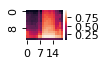

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


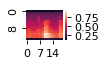

working on batch: 2/150
loading training set
	x shape (before reshape):(289, 14, 20)
	x shape (after reshape):(289, 14, 20, 1)
	y shape:(289, 30)


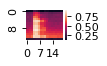

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


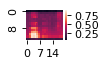

working on batch: 3/150
loading training set
	x shape (before reshape):(289, 14, 20)
	x shape (after reshape):(289, 14, 20, 1)
	y shape:(289, 30)


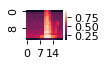

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


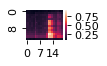

working on batch: 4/150
loading training set
	x shape (before reshape):(289, 14, 20)
	x shape (after reshape):(289, 14, 20, 1)
	y shape:(289, 30)


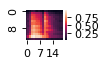

loading validation set
	x shape (before reshape):(97, 14, 20)
	x shape (after reshape):(97, 14, 20, 1)
	y shape:(97, 30)


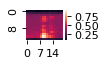

In [5]:
batch_count = 1 # using a counter since enumerate doesn't work on skf.split
total_splits = 150
skf = StratifiedKFold(n_splits=total_splits, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X_master, y_master):
    if batch_count >= 5:
        break

    print(f'working on batch: {batch_count}/{total_splits}')
    rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=42)
    X, y = X_master[test_index], y_master[test_index]
    for train_index2, test_index2 in rs.split(X):
        X_train, X_val = X[train_index2], X[test_index2]
        y_train, y_val = y[train_index2], y[test_index2]
        # Split is done, X=filename, y=target
        
        ttv = []
        x_sizes = []
        y_sizes = []
        
        X_train, y_train = train_val_load(X_train, y_train, mapping, num_classes, train_or_val = 'train')
        X_train, y_train = list(X_train), list(y_train)
        for i, image in enumerate(X_train):
            ttv.append('train')
            x_sizes.append(image.shape[1])
            y_sizes.append(image.shape[0])
            X_train[i] = encode_array_for_sql(image)
            y_train[i] = encode_array_for_sql(y_train[i])
            
        X_val, y_val = train_val_load(X_val, y_val, mapping, num_classes, train_or_val = 'val')    
        X_val, y_val = list(X_val), list(y_val)
        for i, image in enumerate(X_val):
            ttv.append('val')
            x_sizes.append(image.shape[1])
            y_sizes.append(image.shape[0])
            X_val[i] = encode_array_for_sql(image)
            y_val[i] = encode_array_for_sql(y_val[i])
            
        temp_df = pd.DataFrame({'t_t_v':ttv,'words':y_train+y_val,'x_size':x_sizes,'y_size':y_sizes,'images':X_train+X_val})
#         temp_df.to_sql('specgrams', conn, if_exists='replace', index=False)
        temp_df.to_sql('specgrams', conn, if_exists='append', index=False)
        
        X_train, y_train, X_val, y_val = [],[],[],[]
    batch_count += 1

## Confirming that the data was stored properly

In [6]:
verification_df = pd.read_sql('SELECT * FROM specgrams', conn)
verification_df

,t_t_v,words,x_size,y_size,images
0,train,                                              ...,20,14,-=³=$d=0µ¿=0DÁ=*Å¦=*Å¦='Ü=¼>o>3-Ì=8ÿ>]?Äj...
1,train,                                              ...,20,14,r G>ã8>{\tm>9#>¡½>Lh>   >B{©>r §>&´>«ªª>B...
2,train,  ?                                          ...,20,14,ÓA>5 ;>¾kK>¾kK>/¡=>%M>|ðA>Ø}>>Z?>5>%M>)P...
3,train,  ?                                          ...,20,14,0Û=ÄÃÃ=º¹¹=º¹¹=r Ç=ÄÃÃ=«ªª=*Ô=9ã=\±=|&Ñ=%z...
4,train,                                              ...,20,14,ØßÅ=£ÄÏ=²õÜ=ú Ç=HZ=9ã=>l¢>6¶>ÉÝ¾>ÉÝ¾>QG...
...,...,...,...,...,...
1538,val,                                              ...,20,14,;\=lËt=W#=.:=N ®=ãQ9>r Ç>ì>_>Þç;>«>µ~¥=¿R...
1539,val,                                  ?          ...,20,14,"³=L,M=2k=«ª*>c¼|>­p>»>ÎNË=th =gT¯=gT¯=K..."
1540,val,                                              ...,20,14,3ê=MÔ=ÏúÈ=b¨Å=È|÷=àHÑ=¾¬À=°=È|÷=î×ð=åá=çÆ...
1541,val,                                              ...,20,14,:¦=GÚî=úë= öÌ=1¹>1¹>ªÁ>å­Ú>é À>«6>Y _>½...


In [7]:
for index, row in verification_df.iterrows():
    try:
        print(decode_array_from_sql(row.images,row.x_size,row.y_size))
    except:
        print('noooopeee')

noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
noooopeee
